# Canadian Federal Election 2019 Sentiment Analysis

The major purpose of this assignment is to perform sentiment analysis on Tweets regarding 2019 Canadian elections and gain insights.

The assignment will be broken down in to 6 sections which are as follows:

1. Data Cleaning
2. Exploratory Analysis
3. Model preparation
4. Model Implementation
5. Results

## Import Relevant Libaries

In [0]:
!pip install nltk
!pip install WordCloud
!pip install xgboost
!pip install gensim
!pip install pandas
!pip install sklearn
!pip install seaborn
!pip install matplotlib
!pip install gast==0.2.2
!pip install scikit-plot
!pip install tensorflow
!pip install keras

In [0]:
import numpy as np
import pandas as pd
import re, nltk
import string
import html
from html.parser import HTMLParser

from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from collections import Counter

# Plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /Users/jcseok/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jcseok/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
import warnings
warnings.filterwarnings("ignore")

## Read in Data

In [0]:
generic_tweets = pd.read_csv("generic_tweets.txt")
generic_tweets.head()

class          id                          date     query             user  \
0      0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY  _TheSpecialOne_   
1      0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY    scotthamilton   
2      0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY         mattycus   
3      0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          ElleCTF   
4      0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY           Karoli   

                                                text  
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1  is upset that he can't update his Facebook by ...  
2  @Kenichan I dived many times for the ball. Man...  
3    my whole body feels itchy and like its on fire   
4  @nationwideclass no, it's not behaving at all....

In [0]:
generic_tweets = generic_tweets[['class','text']]

In [0]:
election_2019 = pd.read_csv("Canadian_elections_2019.csv")
election_2019.head()

sentiment                      negative_reason  \
0  negative  Women Reproductive right and Racism   
1  positive                                  NaN   
2  negative                              Economy   
3  positive                                  NaN   
4  negative                              Economy   

                                                text  
0  b"@RosieBarton So instead of your suggestion, ...  
1  b"#AllWomanSpacewalk it's real!\n@Space_Statio...  
2  b"#Brantford It's going to cost YOU $94 BILLIO...  
3  b"#Canada #CanadaElection2019 #CanadaVotes \n#...  
4  b"#Canada #taxpayers are sick &amp; tired of h...

## 1.0 Data Cleaning

The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’.
Therefore, the first step is to “clean” the data. Design a procedure that prepares the
Twitter data for analysis by satisfying the requirements below.
* All html tags and attributes (i.e., /<[^>]+>/) are removed.
* Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
* All URLs are removed.
* All characters in the text are in lowercase.
* All stop words are removed. Be clear in what you consider as a stop word.
* If a tweet is empty after pre-processing, it should be preserved as such.

For removing the stop words, we will use the library nltk, but exclude stopwords that are 'Negative' as they play a large role in sentiment analysis.

In [0]:
negative_words = ['not','aren', "aren't", "arent", "can't", 'cant', 'couldn', "couldn't",'cannot', 
                  'couldnt', 'didn', "didn't", 'didnt', 'don', "don't", 'dont'
                  'doesn', "doesn't", 'doesnt' 'hadn', "hadn't", 'hadnt','hasn','hasnt', 
                  "hasn't", 'haven', "haven't", 'havent','isn', "isn't", 'isnt'
                  'mightn', "mightn't", 'mustn', "mustn't", 
                  'needn', "needn't", 'neednt','shan', "shan't", 'shouldn',
                  "shouldn't", 'shouldnt', 'wasn', "wasn't",'wasnt', 'weren', "weren't", 
                  'werent','won', "won't",'wont', 'wouldn', "wouldn't",'wouldnt']

In [0]:
#Stop Words in nltk
#elxn43 & cdnpoli are included as the stopword due to 2019 election
stop_nltk = stopwords.words('english') + ['elxn43','cdnpoli']

#Remove Negative Words from NLTK stopwords library
stop_nltk = [word for word in stop_nltk if word not in negative_words]

In [0]:
#Convert to lower case
def lower_case(tweet):
    tweet = tweet.lower()
    return tweet

#Remove all html tags and attributes
def clean_html_tags(tweet):
    tags = re.compile(r'<[^>]+>')
    tweet = re.sub(tags, ' ' , tweet)
    return tweet

#Remove the first letter b" or b' from election 2019 data
def remove_b(tweet):
    if tweet[:2] == 'b\'' or  tweet[:2] == 'b\"':
        tweet = tweet[1:]
    return tweet

#Remove Hex Characters (x90, x89...) 
def remove_hex(tweet):
    tweet = re.sub(r'(\\x(.){2})', ' ',tweet)
    return tweet

#Clean html character code
def clean_html_codes(tweet):
    tweet = html.unescape(tweet)
    return tweet

#Remove all URL
def URL_removed(tweet):
    tweet = re.sub('\w+\.\S+', ' ', tweet)
    tweet = re.sub('www\.\w+\S+', ' ', tweet)
    tweet = re.sub('https?:\/\/\w+\S+', ' ', tweet)
    tweet = re.sub('https?', ' ', tweet)
    tweet = re.sub('https?:\/\/', ' ', tweet) 
    return tweet

#Tokenization - Converting a sentence into list of words
def tokenization(tweet):
    tweet = re.split('\W+', tweet)
    return tweet

#Remove Stop words using nltk list 
def remove_stop_words(tweet):
    tweet = [word for word in tweet if word not in stop_nltk] 
    return tweet    

#Remove Punctuation
def remove_punc(tweet):
    tweet = [char for char in tweet if char not in string.punctuation]
    return tweet

#Lemmatize the words
wn = nltk.WordNetLemmatizer()

def lemmatizer(tweet):
    tweet = [wn.lemmatize(word) for word in tweet]
    return tweet    


In [0]:
def clean_data(data):
    
    data = data.apply(lambda x: lower_case(x))
    data = data.apply(lambda x: remove_hex(x))
    data = data.apply(lambda x: clean_html_tags(x))
    data = data.apply(lambda x: clean_html_codes(x))  
    data = data.apply(lambda x: remove_b(x))  
    data = data.apply(lambda x: URL_removed(x))
    data = data.apply(lambda x: tokenization(x))    
    data = data.apply(lambda x: remove_stop_words(x))   
    data = data.apply(lambda x: remove_punc(x)) 
    data = data.apply(lambda x: lemmatizer(x)) 
   
    return data

In [0]:
generic_tweets['clean'] = clean_data(generic_tweets['text'])
election_2019['clean'] = clean_data(election_2019['text'])

In [0]:
generic_tweets['clean_joined'] = generic_tweets['clean'].apply(lambda x: ' '.join(x))
election_2019['clean_joined'] = election_2019['clean'].apply(lambda x: ' '.join(x))

In [0]:
generic_tweets.head()

class                                               text  \
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1      0  is upset that he can't update his Facebook by ...   
2      0  @Kenichan I dived many times for the ball. Man...   
3      0    my whole body feels itchy and like its on fire    
4      0  @nationwideclass no, it's not behaving at all....   

                                               clean  \
0  [switchfoot, awww, bummer, shoulda, got, david...   
1  [upset, update, facebook, texting, might, cry,...   
2  [kenichan, dived, many, time, ball, managed, s...   
3             [whole, body, feel, itchy, like, fire]   
4         [nationwideclass, not, behaving, mad, see]   

                                        clean_joined  
0  switchfoot awww bummer shoulda got david carr ...  
1  upset update facebook texting might cry result...  
2  kenichan dived many time ball managed save 50 ...  
3                    whole body feel itchy like fire  
4               nationwideclass not behaving mad see

In [0]:
election_2019.head()

sentiment                      negative_reason  \
0  negative  Women Reproductive right and Racism   
1  positive                                  NaN   
2  negative                              Economy   
3  positive                                  NaN   
4  negative                              Economy   

                                                text  \
0  b"@RosieBarton So instead of your suggestion, ...   
1  b"#AllWomanSpacewalk it's real!\n@Space_Statio...   
2  b"#Brantford It's going to cost YOU $94 BILLIO...   
3  b"#Canada #CanadaElection2019 #CanadaVotes \n#...   
4  b"#Canada #taxpayers are sick &amp; tired of h...   

                                               clean  \
0  [rosiebarton, instead, suggestion, agree, cana...   
1  [allwomanspacewalk, real, n, space_station, n,...   
2  [brantford, going, cost, 94, billion, next, 4,...   
3  [canada, canadaelection2019, canadavotes, n, n...   
4  [canada, taxpayer, sick, tired, hard, earned, ...   

                                        clean_joined  
0  rosiebarton instead suggestion agree canadian ...  
1  allwomanspacewalk real n space_station n etobi...  
2  brantford going cost 94 billion next 4 year as...  
3  canada canadaelection2019 canadavotes n n ncan...  
4  canada taxpayer sick tired hard earned donated...

## 2.0 EDA(Explanatory Data Analysis)

Design a simple procedure that determines the political party (Liberal, Conservative,
NDP, None) of a given tweet and apply this procedure to all the tweets in the 2019
Canadian elections dataset. A suggestion would be to look at relevant words and
hashtags in the tweets that identify to certain political parties. 

#### Keywords to Search for Different Political Parties

1. Liberal Party
    * Leader: Justin Trudeau
    * Slogan: "Forward Change"
    * Keywords: justin, trudeau, justintrudeau, liberal, liberals, forwardchange, forward change

2. Conservative Party:
    * Leader: Andrew Sheer
    * Slogan: “It’s time for you to get ahead”
    * Keywords: andrew, sheer, andrewsheer, conservative, conservatives, timegetahead, time get ahead

3. NDP:
    * Leader: Jagmeet Singh
    * Slogan: "In it for you"
    * Keywords: jagmeet, singh,jagmeetsignh,ndp,newdemocractic,newdemocraticparty, initforyou

    
For all other parties and none, we will classify them as 'other'

In [0]:
liberal = ['justin', 'trudeau', 'justintrudeau', 'liberal', 'liberals','liberalparty', 'forwardchange', 'forward change', 'choose forward','chooseforward']
conservative = ['andrew', 'scheer', 'andrewsheer', 'conservative', 'conservatives', 'conservativeparty', 'timegetahead', 'time get ahead','itstimeforyoutogetahead']
ndp = ['jagmeet', 'singh','jagmeetsignh','ndp','ndps','newdemocratic','newdemocraticparty', 'initforyou', 'new democratic','uprisingh']


In [0]:
#Function for grouping parties based on the tweets
def party(tweets):
    
    party_count = {'liberal':0, 'conservative':0, 'ndp':0}
    
    for word in liberal:
        if word in tweets:
            party_count['liberal']+=1
    
    for word in conservative:
        if word in tweets:
            party_count['conservative']+=1

    for word in ndp:
        if word in tweets:
            party_count['ndp'] += 1
    
    #Returns the party with highest keyword count in a tweet
    if sum(party_count.values()) > 0:
        return max(party_count, key=party_count.get)
    elif sum(party_count.values()) == 0 :
        return 'other'

In [0]:
generic_tweets['party'] = generic_tweets['clean_joined'].apply(lambda x: party(x))
election_2019['party'] = election_2019['clean_joined'].apply(lambda x: party(x))

In [0]:
generic_tweets['party'].value_counts()

other           199407
liberal            232
conservative       198
ndp                163
Name: party, dtype: int64

In [0]:
election_2019['party'].value_counts()

other           980
liberal         553
conservative    412
ndp             188
Name: party, dtype: int64

In [0]:
#Count plot graph function
def countplot(x, data, order ):
    plt.figure(figsize=(18,6))
    sns.set(style="darkgrid")
    ax= sns.countplot(x=x, data=data, order = order)
    plt.tight_layout()

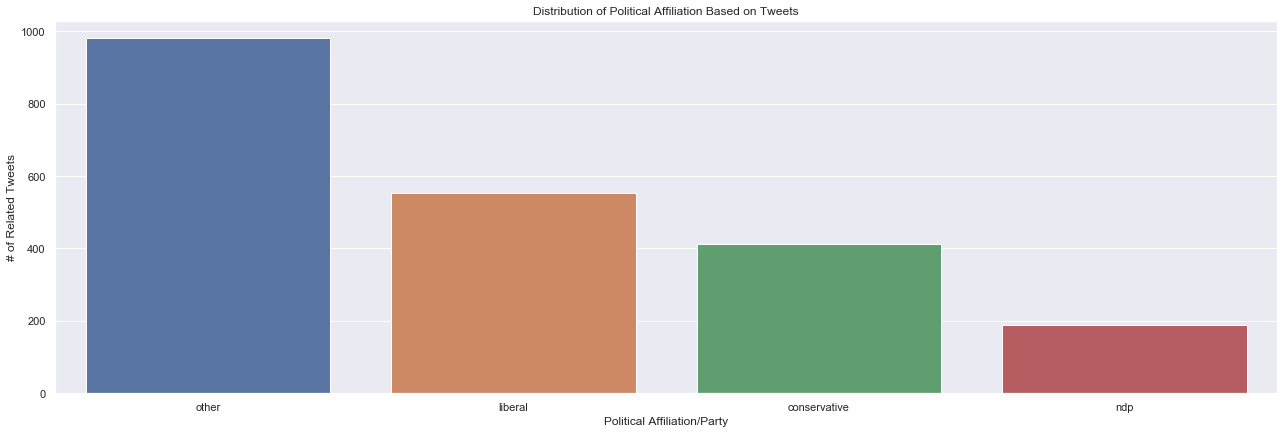

In [0]:
#Election 2019 Data Political Party Distribution
index = election_2019['party'].value_counts().index

countplot('party', election_2019, order = index)
plt.title("Distribution of Political Affiliation Based on Tweets")
plt.xlabel("Political Affiliation/Party")
plt.ylabel("# of Related Tweets")
plt.show()

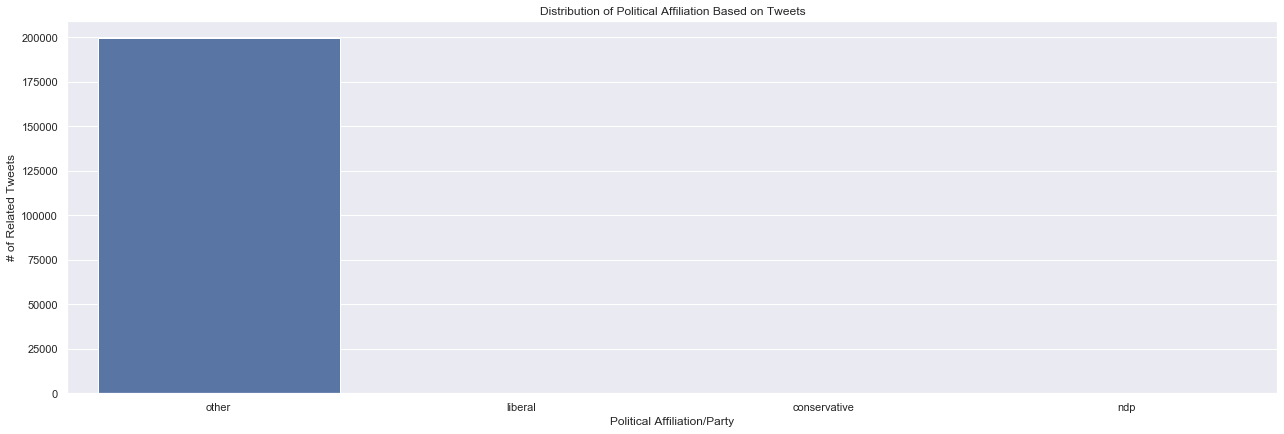

In [0]:
#Generic Data Political Party Distribution
countplot('party', generic_tweets, order = index)
plt.title("Distribution of Political Affiliation Based on Tweets")
plt.xlabel("Political Affiliation/Party")
plt.ylabel("# of Related Tweets")
plt.show()

**Question: What can you say about the distribution of the political affiliations of the tweets?**

In the generic tweets data, almost all data were classified as the "Other", and very few were classified as either liberal, conservative and ndp. This is mainly because the tweets have been extracted in the 2009s which mean our keyword such as slogans and leader names aren't applicable as the classification methods. It only applies for 2019 election. Therefore, for determining the political insight about the 2019 election, the distribution of the generic tweeets won't help us much. 

In the 2019 election data, the distribution of the parties show that most of the tweets are identified as other as these tweets don't contain any keyword in the list. The class, 'other' can represent that tweets don't have any mentioning of the three major parties or tweets represented political parties other than the three parties we chose. If we had classes for all political parties, the data would be less concentrated towards the 'other'.

Looking at those that are classified, liberals have the highest frequency, followed by the conservative and the ndp. This does make sense, because for 2019 election, liberals gained the most seats followed by the conservative then the ndp. Also, the most two competitive parties, liberal and conservative both have highest tweet counts. 




### Bonus - Word Cloud - Negative Words in Generic Tweets

In [0]:
negative_words = [x for x in generic_tweets[generic_tweets['class']==0]['clean_joined']]
negative_words = " ".join(negative_words)

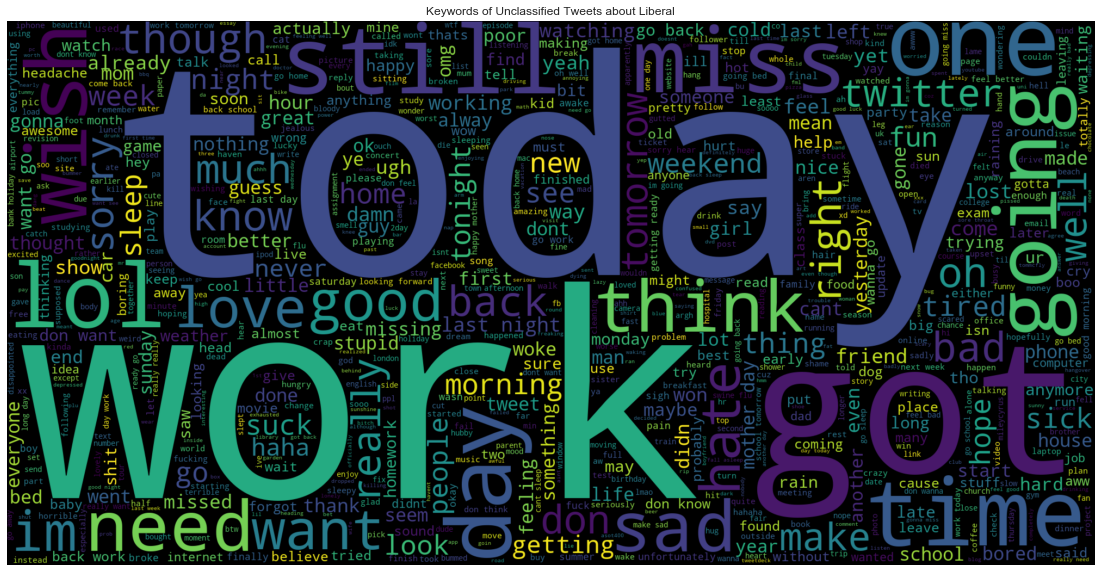

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=800).generate(negative_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the generic tweets that were classified as negative, words with high frequency seems to have neutral sentiment values. I can see some smaller words like hate, suck, and other negative words. Also, the word "work" seemed to have high frequency in the negative tweets. This might imply that people tend to express negative sentiment towards work in their tweets. 

### Bonus - Word Cloud - Negative Words in Generic Tweets

In [0]:
positive_words = [x for x in generic_tweets[generic_tweets['class']==4]['clean_joined']]
positive_words = " ".join(positive_words)

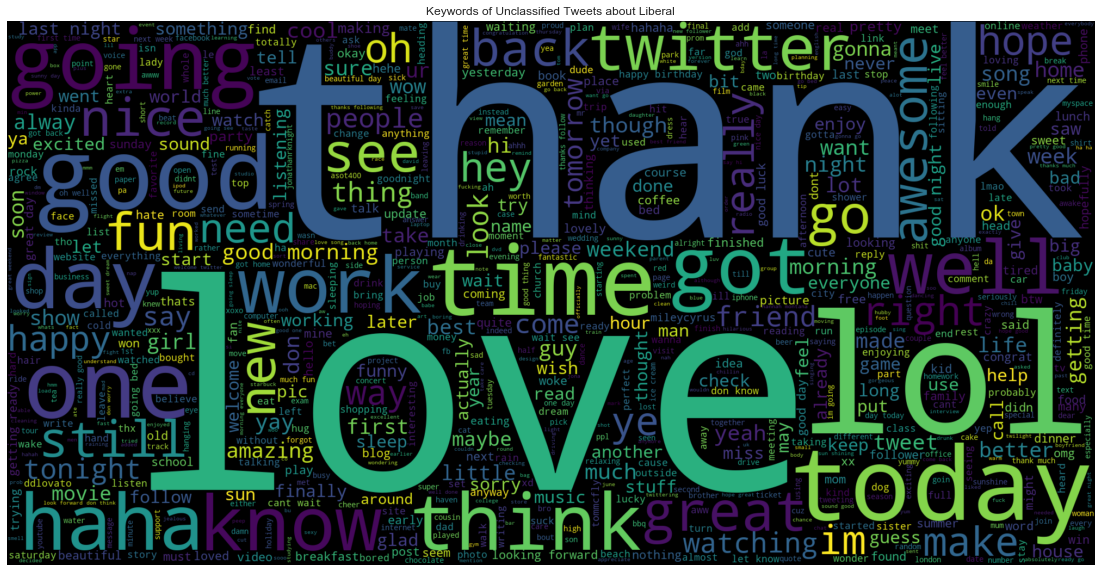

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=800).generate(positive_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the generic tweets that were classified as positive, words with high frequency seems to have positive sentiment values. Large words like "thank", "love", "lol", etc. are words with positive sentiments.

### Bonus - Word Cloud - Liberals

In [0]:
liberal_words = [x for x in election_2019[election_2019['party']=='liberal']['clean_joined']]
liberal_words = " ".join(liberal_words)

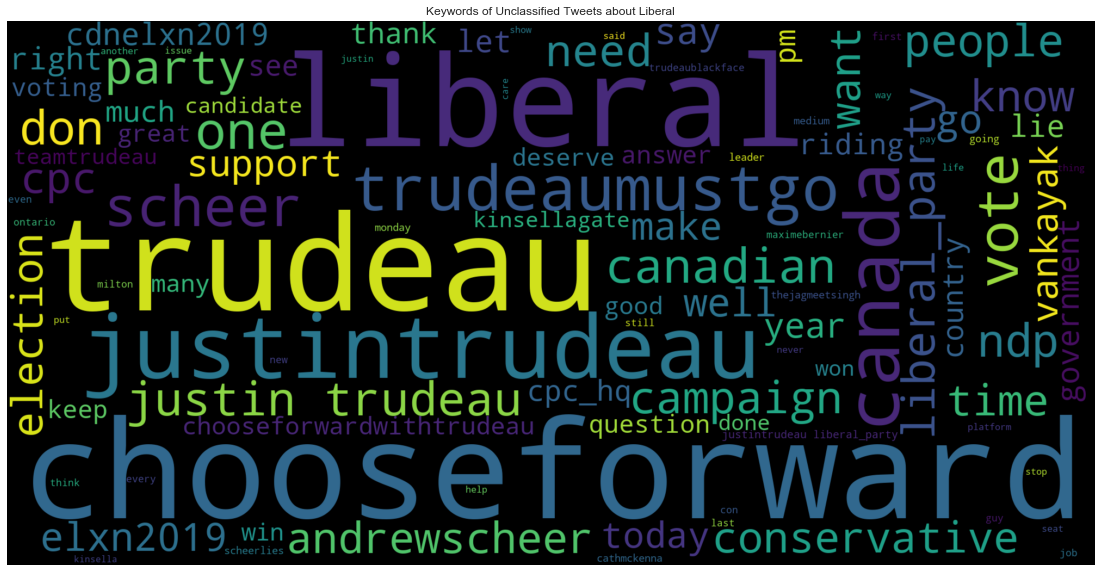

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(liberal_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the word cloud above, we can see keywords like chooseforward, trudeau, liberal, justintrudeau, treaumustgo, etc. which are all related to the liberal party in 2019 election

### Bonus - Word Cloud - Conservatives

In [0]:
conservative_words = [x for x in election_2019[election_2019['party']=='conservative']['clean_joined']]
conservative_words = " ".join(conservative_words)

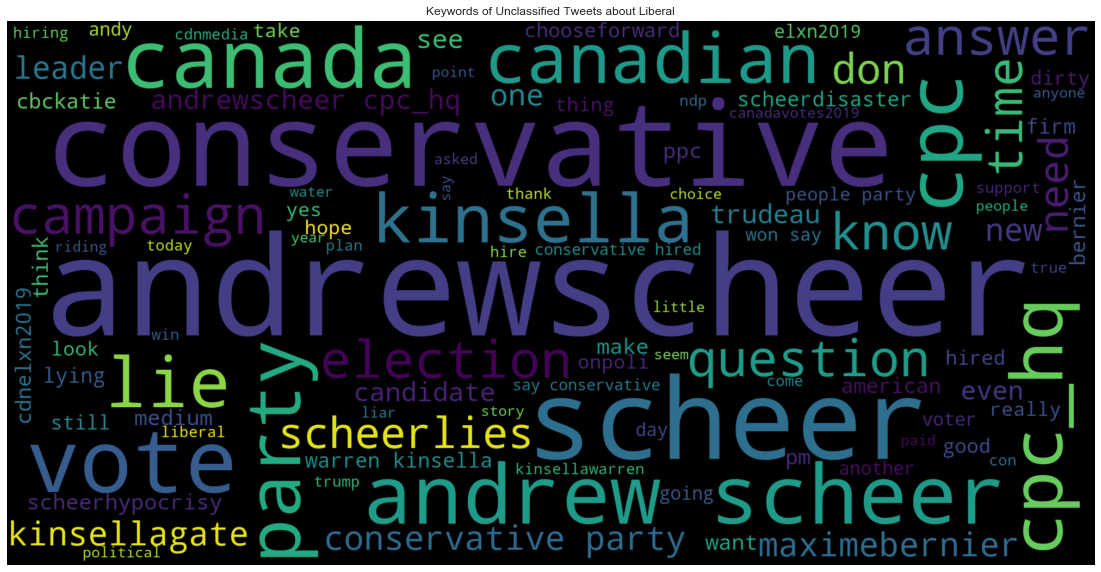

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(conservative_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the word cloud above, we can see keywords like andrew scheer, conservative party, conservative, etc. which are all related to the conservative party in 2019 election

### Bonus - Word Cloud - NDP

In [0]:
ndp_words = [x for x in election_2019[election_2019['party']=='ndp']['clean_joined']]
ndp_words = " ".join(ndp_words)

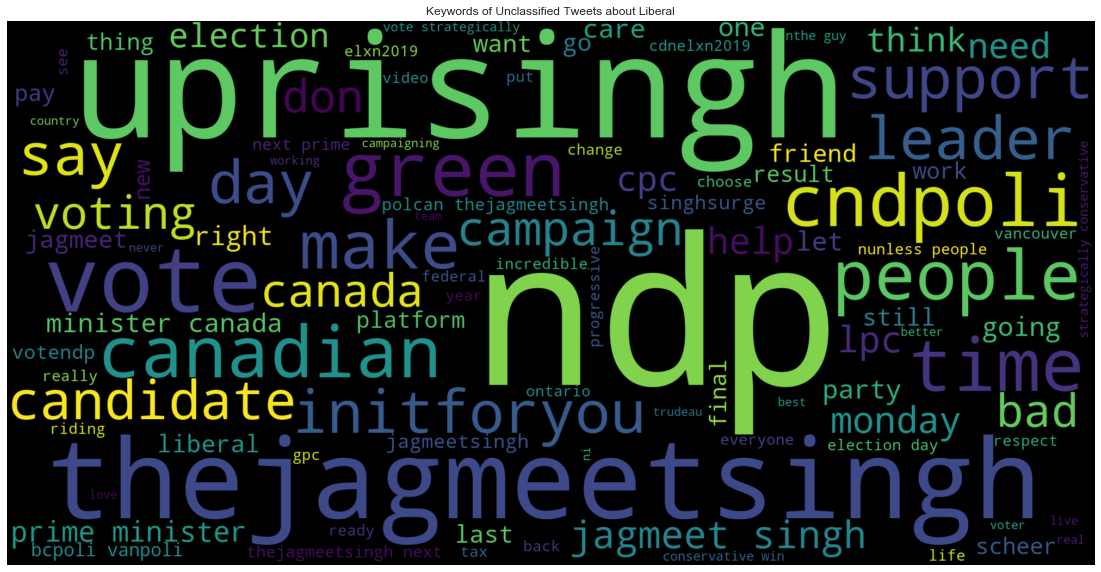

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(ndp_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the word cloud above, we can see keywords like ndp, initforyou, thejagmeetsingh, uprising, etc which are all related to ndp party in 2019 election

### Bonus - Word Cloud - Other

In [0]:
other_words = [x for x in election_2019[election_2019['party']=='other']['clean_joined']]
other_words = " ".join(other_words)

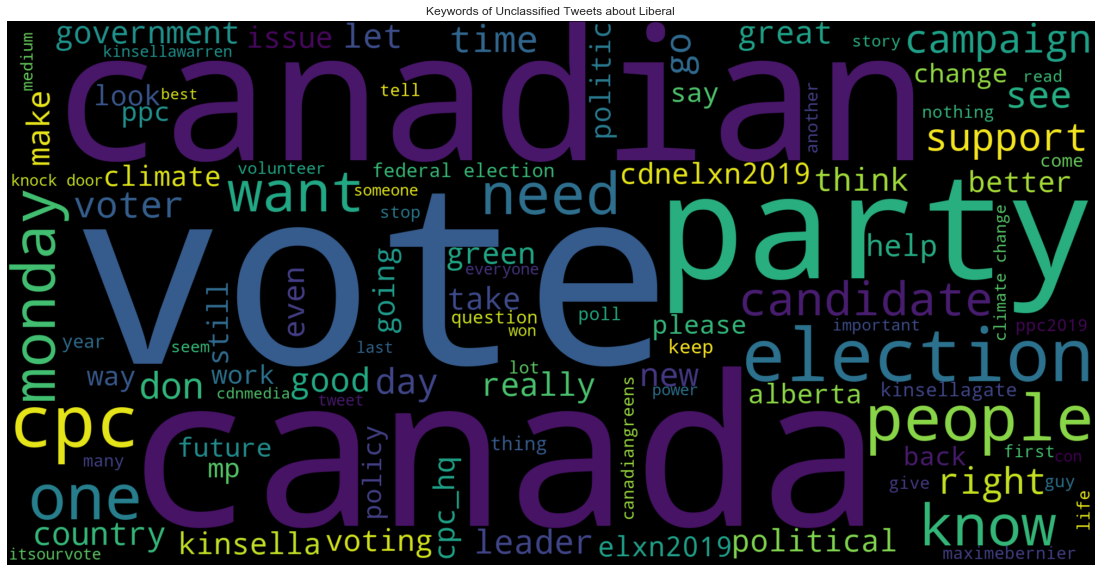

In [0]:
wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(other_words)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Unclassified Tweets about Liberal')
plt.axis("off")
plt.show()

In the word cloud above, we can see keywords like vote, canada, people, support, etc which are all related to the 2019 elections. Also, we do not see any words related to the three parties above which mean that we were able to classify the parties well using the selected keywords.

## 3.0 Model Preparation

In [0]:
X = generic_tweets['clean_joined'].copy()
y = generic_tweets['class'].copy()

In [0]:
election_data = election_2019['clean_joined'].copy()
election_target = election_2019['sentiment'].copy()

In [0]:
#impute negative and postiive to numerical labels
election_class = {'negative':0, 'positive':4}
election_target.replace(election_class, inplace = True)

In [0]:
election_target.head()

0    0
1    4
2    0
3    4
4    0
Name: sentiment, dtype: int64

### Prepare Data Using Bag of Words

Bag of words is an algorithm that counts how many times a word appears in a document. 
* Pros of Bag of Words are:
    * Easy to Compute
* Cons of Bag of Words are:
    * Term ordering is not considered
    * Rareness of the term is not considered

In [0]:
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer

#Set max features to 2000
vectorizer = CountVectorizer(analyzer = "word", max_features = 2000) 

train_data_features = vectorizer.fit_transform(X)

train_data_features = train_data_features.toarray()

feature_names = vectorizer.get_feature_names()

X_BoW = pd.DataFrame(train_data_features, columns = feature_names)

### Prepare Data Using Tfidvectorizer or TF-IDF

TF-IDF is another way for feature extraction in text data. With TF-IDF, words are given weight or measures relevance, not frequency. The more text a word appears, the less valuable that word is as it does not differentiate between different texts.
* Pros of TF-IDF are:
    * Easy to compute
    * Determines highly relevant documents or text
* Cons of TF-IDF are:
    * Makes assumption that counts of different words provide independence evidence of similarity
    * Makes no use of semantic similarities between words

In [0]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Set max features to 2000
tf_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word', max_features = 2000)

train_data_features = tf_vectorizer.fit_transform(X)
train_data_features = train_data_features.toarray()

feature_names = tf_vectorizer.get_feature_names()

X_tf = pd.DataFrame(train_data_features, columns = feature_names)

### Bonus - Prepare Data Using TF-IDF & N-Grams

Instead of taking one out of time, N-gram takes sequence of N words. For instance, if we have words like San Francisco, TF-IDF or Bag of words simply takes words "San" and "Francisco", but 2-gram takes both words, San Francisco.

* Pros of N-Grams:
    * Captures multi-expression word in the text
* Cons of N-Grams:
    * Does not deal with long distance dependencies
    * Creates high sparsity of data

In [0]:
#2-Gram with TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

#Set max features to 2000
ng_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word', max_features = 2000,
                                ngram_range = (1,2))

train_data_features = ng_vectorizer.fit_transform(X)
train_data_features = train_data_features.toarray()

feature_names = ng_vectorizer.get_feature_names()

X_ng = pd.DataFrame(train_data_features, columns = feature_names)

### Split Test and Train Data

In [0]:
from sklearn.model_selection import train_test_split

#Bag of Words
X_train_BoW,X_test_BoW,y_train,y_test = train_test_split(X_BoW,y, test_size = 0.30, random_state = 5)

In [0]:
#TF-IDF
X_train_tf,X_test_tf = train_test_split(X_tf, test_size = 0.30, random_state = 5)

In [0]:
from sklearn.model_selection import train_test_split

#N-Gram
X_train_ng,X_test_ng = train_test_split(X_ng, test_size = 0.30, random_state = 5)

## 4.0 Model implementation

### 4.1 Sentimental Prediction

**Train models on the training data and apply the model to the test data to obtain an
accuracy value. Evaluate the same model with best performance on the 2019 Canadian
elections data**

### 4.1.1 Generic Tweet Data

For training the generic tweet data, we will use the following classifiers:

* **Logistic Regression** - Logistic regression determines the relationship between the dependent variable and the target variables through estimating the probabilites using the logistic/sigmoid function
    * The Pros of Logistic regression are:
        * Easy to imeplement and very efficient to train. 
        * Does not require a lot of tuning and is easy to regularize
    * The Cons of Logistic regression are:
        * Cannot solve non-linear problems
        * Relies heavily on the proper presentation of the data
        
* **Naive Bayes** - Naive Bayes classifer is a probabilistic machine learning algorithm based Bayes Theorem with the assumption of conditional independence between the input variables.
    * The Pros of Naive Bayes are:
        * Easy and fast to predict classes
        * With the assumption of independence, less training data can result in better performance compared to models like logistic regression
    * The Cons of Naive Bayes are:
        * The assumption of independence in the input variable can result in worse prediction. In real life, it is almost impossible to get set of variables that are completely independent.

* **SVM Classifier** - SVM or Support vector machine algorithm finds a hyperplane in the N-dimensional space and the hyperplane works as a boundary for classification of the data.
    * The Pros of SVM Classifier are:
        * Tends to perform well in high dimensional spaces
        * Memory efficient as it uses subset of the training points in the decision functions (or support vectors)
    * The Cons of SVM Classifier are:
        * Prone for overfitting, if the number of features are higher than the number of samples
        * SVM does not provide probaility estimates, which are useful in most classification problems

* **XGBoost** - XGBoost or eXtreme Gradient Boosting classifier is becoming one of the popular machine learning algorithm these days. The classifier is based on gradient boosted decision trees. Gradient boosting creates new models that predict the errors of the prior models then combine to make the final prediction. It is called gradient boosting, because it uses gradient descent algorithm to minimize the loss when creating new models.
    * The Pros of XGBoost are:
        * Usually generates better results than other tree ensemble models such as Random Forest
    * The Cons of XGBoost are:
        * Takes long time to train and harder to tune as there are a lot of parameters.
* **Decision Tree** - Decision tree is a decision support tool that utilizes the tree-like graph or tree of decisions and their possible outcomes. 
    * The Pros of Decision Tree are:
        * Requires less effort for preprocessing the data as it does not require normalization, scaling, etc.
    * The Cons of Decision Tree are:
        * Computationally expensive to run
        * Sensitive to the hyperparameters

* **KNN** - KNN works by classifying the majority of the classes of the n-nearest neighbors or datapoints.
    * The Pros of KNN are:
        * Very easy to implement
    * The Cons of Decision Tree are:
        * Doesn't perform well on imbalanced data
        * Doesn't perform well on dataset with high dimensionality
        
* **Random Forest** - Random forest consists of large number of individual decision trees that operate as an emsemble. Each tree makes prediction on the class and the class with highest count becomes the model's prediction.
    * The Pros of Random Forest are:
        * Can handle large data sets with high dimensionality
        * Works well with imbalanced data
    * The Cons of Decision Tree are:
        * Little control on how to perform the model
        * Doesn't perform well on continuous data

In addition, we will train using the classifiers above on dataset featurized with bag of words, TF-IDF and N-grams(Bonus) and determine which model results in the highest accuracy. 

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('SVM', LinearSVC()))
models.append(('XGBoost', XGBClassifier()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append(('RandomForest',RandomForestClassifier()))

#### Bag of Words

In [0]:
#Fitting Models on data featurized with Bag of Words

for classifier, model in models:
    model.fit(X_train_BoW, y_train)
    y_train_pred = model.predict(X_train_BoW)
    y_test_pred = model.predict(X_test_BoW)
    train_accuracy = accuracy_score(y_train, y_train_pred) *100
    test_accuracy = accuracy_score(y_test, y_test_pred) *100
    
    print("With Classifier: {}, Train Accuracy: {:.2f}, and Test Accuracy {:.2f}".format(classifier,train_accuracy,test_accuracy))    
    

With Classifier: Logistic Regression, Train Accuracy: 76.80, and Test Accuracy 75.81
With Classifier: Naive Bayes, Train Accuracy: 75.63, and Test Accuracy 74.98
With Classifier: SVM, Train Accuracy: 76.71, and Test Accuracy 75.79
With Classifier: XGBoost, Train Accuracy: 67.87, and Test Accuracy 67.52
With Classifier: DecisionTree, Train Accuracy: 97.27, and Test Accuracy 68.95
With Classifier: RandomForest, Train Accuracy: 95.95, and Test Accuracy 72.92


Using Bag of Words, the classifier with best accuracy is logistic regression with accuracy of 75.81%

#### TF - IDF

In [0]:
#Fitting Models on data featurized with TF-IDF
for classifier, model in models:
    model.fit(X_train_tf, y_train)
    y_train_pred = model.predict(X_train_tf)
    y_test_pred = model.predict(X_test_tf)
    train_accuracy = accuracy_score(y_train, y_train_pred) *100
    test_accuracy = accuracy_score(y_test, y_test_pred) *100
    
    print("With Classifier: {}, Train Accuracy: {:.2f}, and Test Accuracy {:.2f}".format(classifier,train_accuracy,test_accuracy))    


With Classifier: Logistic Regression, Train Accuracy: 76.77, and Test Accuracy 75.81
With Classifier: Naive Bayes, Train Accuracy: 75.41, and Test Accuracy 74.60
With Classifier: SVM, Train Accuracy: 76.24, and Test Accuracy 75.25
With Classifier: XGBoost, Train Accuracy: 67.87, and Test Accuracy 67.52
With Classifier: DecisionTree, Train Accuracy: 97.27, and Test Accuracy 69.03
With Classifier: RandomForest, Train Accuracy: 96.04, and Test Accuracy 72.53


Using TF-IDF, the classifier with best accuracy is logistic regression with accuracy of 75.81%.

#### TF-IDF with N-Grams

In [0]:
#Fitting Models on data featurized with TF-IDF & 2-Gram
for classifier, model in models:
    model.fit(X_train_ng, y_train)
    y_train_pred = model.predict(X_train_ng)
    y_test_pred = model.predict(X_test_ng)
    train_accuracy = accuracy_score(y_train, y_train_pred) *100
    test_accuracy = accuracy_score(y_test, y_test_pred) *100
    
    print("With Classifier: {}, Train Accuracy: {:.2f}, and Test Accuracy {:.2f}".format(classifier,train_accuracy,test_accuracy))    

With Classifier: Logistic Regression, Train Accuracy: 76.95, and Test Accuracy 76.07
With Classifier: Naive Bayes, Train Accuracy: 75.48, and Test Accuracy 74.75
With Classifier: SVM, Train Accuracy: 76.48, and Test Accuracy 75.61
With Classifier: XGBoost, Train Accuracy: 67.94, and Test Accuracy 67.55
With Classifier: DecisionTree, Train Accuracy: 97.04, and Test Accuracy 68.82
With Classifier: RandomForest, Train Accuracy: 95.78, and Test Accuracy 72.61


Using TF-IDF with N-Grams, the classifier with best accuracy is logistic regression with accuracy of 76.07%.

Dataset featurized using TF-IDF with N-Gram and logistic regression resulted us the best accuracy of 76.07%. Therefore, we will use logistic regression to perform the election data.

#### Bonus - Nerual Network

Since logistic regression was the best performing classifier, I thought that using neural network would help to achieve higher performance, because logistic regression can be interpreted as neural network with no hidden layer. 

To implement the neural network model, we will use the data featurized with bag of words and use the library Tensorflow. Also, unlike other classifiers, we will split our data into train, test and validation. When training, early stopping will be implemented to ensure the model doesn't overfit to the train set. 

In [0]:
import tensorflow as tf

In [0]:
#Split the Train data into Train data and validation data
X_train_ml,X_val_ml,y_train_ml,y_val_ml = train_test_split(X_train_ng,y_train, test_size = 0.20)

In [0]:
#Convert Pandas data frame into np.array
X_train_ml = X_train_ml.values
X_val_ml = X_val_ml.values
y_train_ml = y_train_ml.values
y_val_ml = y_val_ml.values

In [0]:
#Convert Pandas data frame into np.array
X_test_ml = X_test_ng.values
y_test_ml = y_test.values

In [0]:
#Map the values 4 into 1 as tensorflow wants values from 0 - 1 for categorical target
y_train_ml =np.where(y_train_ml==4, 1, y_train_ml)
y_test_ml =np.where(y_test_ml==4, 1, y_test_ml)
y_val_ml =np.where(y_val_ml==4, 1, y_val_ml)

In [0]:
# Set the input and output sizes
input_size = 500
output_size = 2
hidden_layer_size = 5
    
model = tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(output_size, activation='sigmoid') # output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# set the batch size
batch_size = 100

# set a maximum number of training epochs
max_epochs = 20

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
model.fit(X_train_ml, # train inputs
          y_train_ml, # train targets
          batch_size=batch_size, # batch size
          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
          # callbacks are functions called by a task when a task is completed
          # task here is to check if val_loss is increasing
          validation_data=(X_val_ml, y_val_ml), # validation data
          callbacks=[early_stopping], # early stopping
          )  

Train on 112000 samples, validate on 28000 samples
Epoch 1/20
112000/112000 [==============================] - 11s 97us/sample - loss: 0.5426 - accuracy: 0.7319 - val_loss: 0.5051 - val_accuracy: 0.7578
Epoch 2/20
112000/112000 [==============================] - 6s 51us/sample - loss: 0.4901 - accuracy: 0.7630 - val_loss: 0.4973 - val_accuracy: 0.7600
Epoch 3/20
112000/112000 [==============================] - 5s 40us/sample - loss: 0.4781 - accuracy: 0.7686 - val_loss: 0.4962 - val_accuracy: 0.7596
Epoch 4/20
112000/112000 [==============================] - 5s 41us/sample - loss: 0.4704 - accuracy: 0.7711 - val_loss: 0.4976 - val_accuracy: 0.7592
Epoch 5/20
112000/112000 [==============================] - 5s 43us/sample - loss: 0.4642 - accuracy: 0.7749 - val_loss: 0.5001 - val_accuracy: 0.7585


In [0]:
#Get Loss and Train accuracy
loss,accuracy = model.evaluate(X_test_ml, y_test_ml)

60000/60000 [==============================] - 6s 93us/sample - loss: 0.5030 - accuracy: 0.7556


Without any parameter tuning, we are able to achieve 75.56% on test accuracy. It seems like logistic regression outperforms the neural network. Neural network does require tuning on many variables or parameters, so when proper tuning is applied, there is a high chance that neural network will outperform logistic regression.

We will use logistic regresssion for predicting the election data as it had the best performance among all classifiers.

### 4.1.2 Election 2019 Data

**Evaluate the same model with best performance on the 2019 Canadian
elections data.**

Among all the classifier, the best performing model with highest accuracy was with Logistic Regression with feature extraction method as N-Gram. Therefore, we will use trained logistic regression model from above to predict the sentiment of the data in election 2019.

In [0]:
#Fit Logistic Regression Model using TF-IDF + 2-Gram dataset
lg_model = LogisticRegression().fit(X_train_ng,y_train)

In [0]:
# Election data
election_data_features = ng_vectorizer.transform (election_data)

election_data_features = election_data_features.toarray()

election_data_ng = pd.DataFrame(election_data_features, columns = feature_names)

In [0]:
election_prediction = lg_model.predict(election_data_ng)
election_accuracy = accuracy_score(election_target, election_prediction) *100

print("Accuracy of the prediction in election data is {:.3f}%".format(election_accuracy))

Accuracy of the prediction in election data is 60.994%


#### Actual and Prediction of Sentiment Visualization

In [0]:
election_results = pd.DataFrame(election_prediction, columns = ['Predicted'])
election_results['Actual'] = election_target
election_results['party'] = election_2019['party']
election_results.head()

Predicted  Actual         party
0          4       0  conservative
1          4       4         other
2          0       0       liberal
3          0       4         other
4          0       0       liberal

In [0]:
#Divide parties into different DataFrame
conservative_result = election_results[election_results['party']=='conservative']
liberal_result = election_results[election_results['party']=='liberal']
ndp_result = election_results[election_results['party']=='ndp']

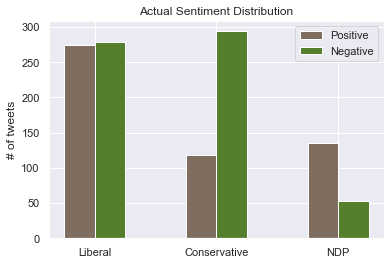

In [0]:
#Convert to dictionary
conservative_result_actual = conservative_result['Actual'].value_counts().to_dict()
liberal_result_actual = liberal_result['Actual'].value_counts().to_dict()
ndp_result_actual = ndp_result['Actual'].value_counts().to_dict()

positive_actual = (liberal_result_actual[4],conservative_result_actual[4], ndp_result_actual[4])
negative_actual = (liberal_result_actual[0],conservative_result_actual[0], ndp_result_actual[0])

barWidth = 0.25
r1 = np.arange(len(positive_actual))
r2 = [x + barWidth for x in r1]

plt.bar(r1, positive_actual, color='#7f6d5f', width=barWidth, edgecolor='white', label='Positive')
plt.bar(r2, negative_actual, color='#557f2d', width=barWidth, edgecolor='white', label='Negative')

plt.xticks([r + barWidth/2 for r in range(len(positive_actual))], ['Liberal','Conservative','NDP'])

plt.ylabel('# of tweets')
plt.title('Actual Sentiment Distribution')
plt.legend()
plt.show()

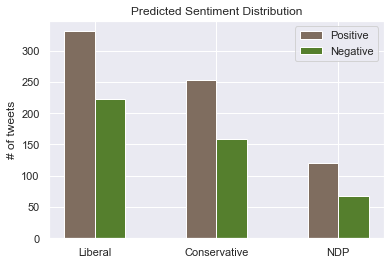

In [0]:
conservative_result_pred = conservative_result['Predicted'].value_counts().to_dict()
liberal_result_pred = liberal_result['Predicted'].value_counts().to_dict()
ndp_result_pred = ndp_result['Predicted'].value_counts().to_dict()

positive_pred = (liberal_result_pred[4],conservative_result_pred[4], ndp_result_pred[4])
negative_pred = (liberal_result_pred[0],conservative_result_pred[0], ndp_result_pred[0])

barWidth = 0.25
r1 = np.arange(len(positive_pred))
r2 = [x + barWidth for x in r1]


fig, ax = plt.subplots()
width = 0.35

plt.bar(r1, positive_pred, color='#7f6d5f', width=barWidth, edgecolor='white', label='Positive')
plt.bar(r2, negative_pred, color='#557f2d', width=barWidth, edgecolor='white', label='Negative')

plt.xticks([r + barWidth/2 for r in range(len(positive_pred))], ['Liberal','Conservative','NDP'])

plt.ylabel('# of tweets')
plt.title('Predicted Sentiment Distribution')
plt.legend()
plt.show()

**How well do your predictions match the sentiment labelled in the 2019
Canadian elections data?**

The accuracy of the sentiment prediction in election data is 61.0%. Compared to the test accuracy on the dataset we trained on, the accuracy of election data is 11% less than the test accuracy of the generic tweet data. The model seems to perform very well on the tweet data, but as good on the election data. In addition, based on the distribution above, it seems like the model is biased towards 'Positive" sentiment values. The result of the model will be discussed more in detail in the result section. 

**Question: Discuss whether NLP analytics based on tweets is useful for
political parties during election campaigns.**

Based on the tweet data we have extracted so far, I would say that NLP analytics based on Tweets definitely add values in analyzing political parties during election campaigns; however, as usual, the conclusion should not be drawn based on the Twitter data alone. 

According to the Global News, Liberal, Conservative, and New Democratic won 157, 121, and 24 seats, respectively. The number of seats won are proportional to the number of tweets in the analysis. It seems like the size of the network/tweets have strong correlation with the chance of winning or the number of seats a party will win.

Sentiment values on the other hand are not very representative in the election 2019 data. Our model was not able to predict very well on the sentiment values, but even if our model predicted well about the sentiment, sentiment does not show a strong relationship between the result of the election. For example, despite NDP having more positive tweets compared to Conservative, seats won by NDP were significantly less as opposed to the Conservative. Also, despite conservative having large number of negative Tweets and relatively small number of positive Tweets, the number of seats they have won are very close to the winning party, liberal.

Based on the result, it seems like the sentiment values do not have strong correlation between the election result. This is because we are only analyzing those that use Twitter which is a small subset of the population. Also, making a conclusion on tweets may not be a great idea, because those that use Twitter tends to be younger which mean that the data is biased. There is definitely a takeways from NLP analytics on tweets data for political parties, but conclusion shouldn't be drawn purely based on the Tweet data.

### 4.2 Negative Reason Prediction

### 4.2.1 Data Preparation

In [0]:
df = election_2019[election_2019['sentiment']=='negative'][['negative_reason','clean_joined']]

df.head()

negative_reason  \
0  Women Reproductive right and Racism   
2                              Economy   
4                              Economy   
5                               Others   
8                               Others   

                                        clean_joined  
0  rosiebarton instead suggestion agree canadian ...  
2  brantford going cost 94 billion next 4 year as...  
4  canada taxpayer sick tired hard earned donated...  
5  canadavotes2019 fact blastfromthepast 2012 con...  
8  chooseforward ncanada don make america mistake...

In [0]:
df['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

Based on the distribution, the target variable, 'Separation', Privilege, Healthcare, and Healthcare and Marijuana does not have enough data points to achieve a good predictive model on. Therefore, we will impute these target variables to 'Others'

In [0]:
df['negative_reason'] = df['negative_reason'].replace({'Separation':'Others', 'Privilege':'Others', 
                                                       'Healthcare':'Others', 'Healthcare and Marijuana': 'Others'})
df['negative_reason'].value_counts()

Others                                 401
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Name: negative_reason, dtype: int64

### 4.2.2 EDA

### Distribution

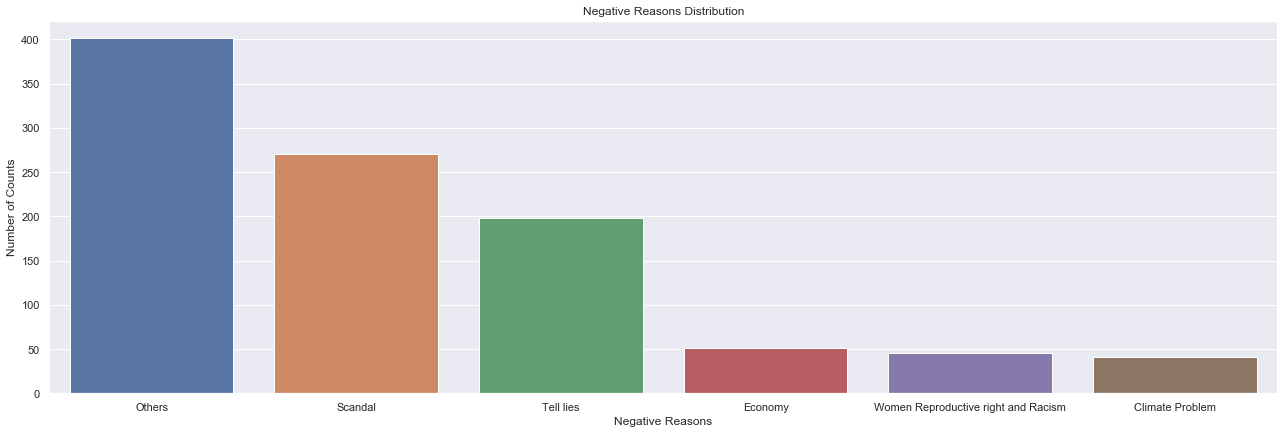

In [0]:
#Election 2019 Data Political Party Distribution
index = df['negative_reason'].value_counts().index

countplot('negative_reason', df, order = index)
plt.title("Negative Reasons Distribution")
plt.xlabel("Negative Reasons")
plt.ylabel("Number of Counts")
plt.show()

Despite eliminating few classes, the dataset is skwed meaning it is imbalanced. Also, the dataset is significantly smaller compared to the dataset used for sentiment prediction.

### Word Cloud

We will examine which keywords are frequently used in Scandal, Tell lies, and others which are the top 3 highest count negative reasons.

#### Scandal

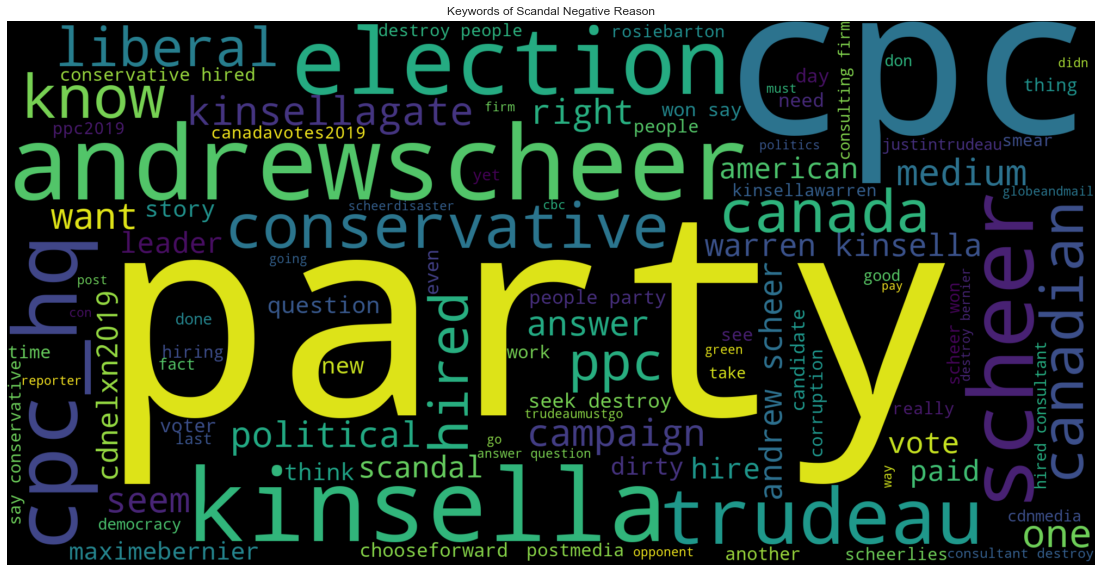

In [0]:
scandal = [x for x in df[df['negative_reason']=='Scandal']['clean_joined']]
scandal = " ".join(scandal)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(scandal)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Scandal Negative Reason')
plt.axis("off")
plt.show()

The major keywords in the wordcloud like cpc and andrewscheer, all represents or are related to conservative party. It seems like a lot of scandals are from the conservative party. Also, we can see words like 'scandal' which should help in our data modelling.

#### Tell Lies

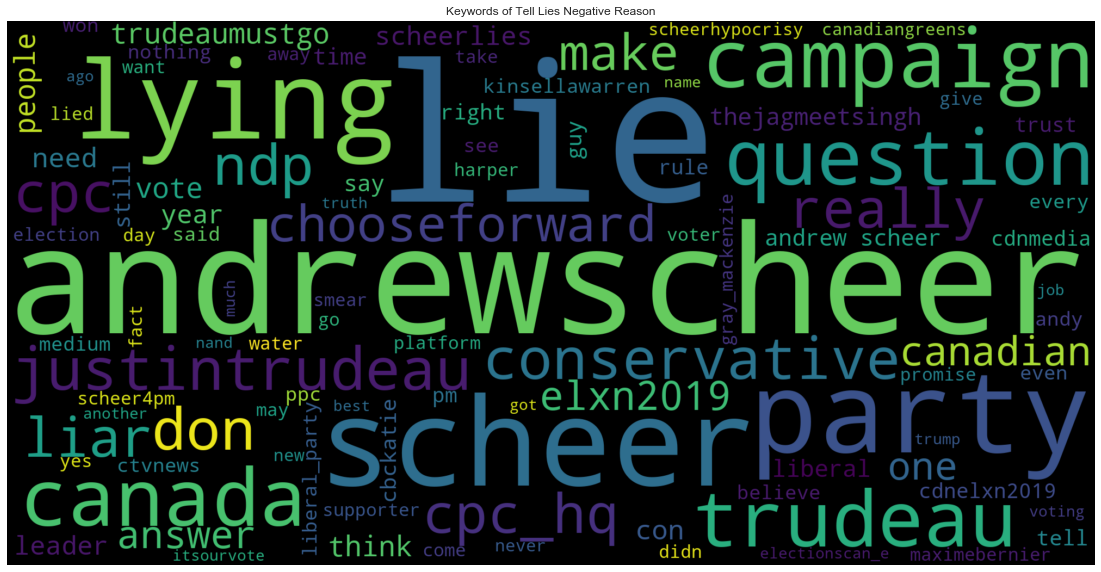

In [0]:
lies = [x for x in df[df['negative_reason']=='Tell lies']['clean_joined']]
lies = " ".join(lies)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(lies)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Tell Lies Negative Reason')
plt.axis("off")
plt.show()

Again, the keywords in the word cloud are mostly associated with the conservative parties. When it comes to telling lies and scandals, conservative parties take up majority of the tweets. Also, we can see words like lie which will help us with data modeling.

#### Others

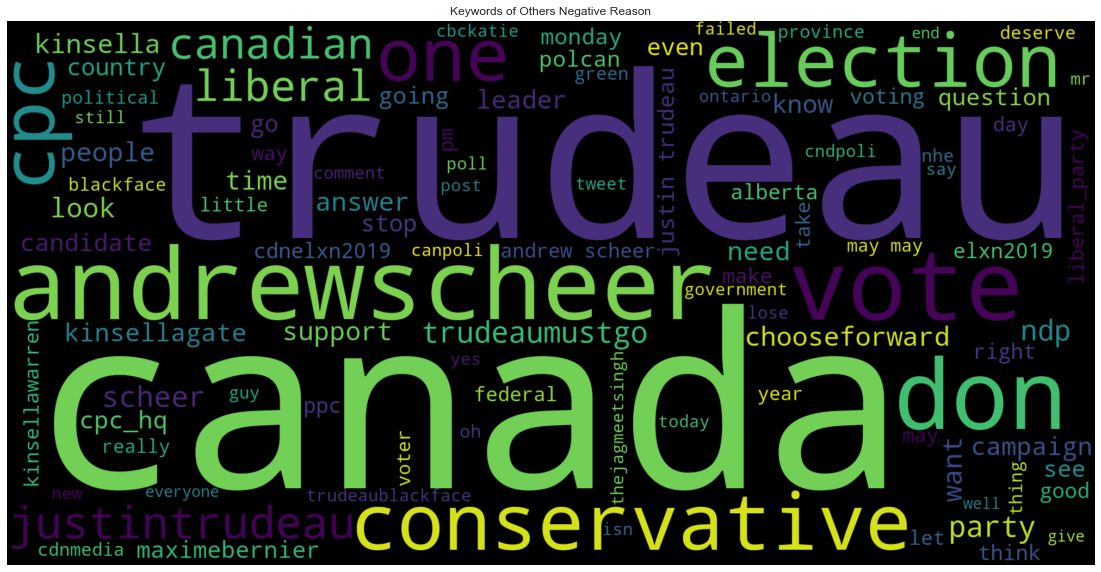

In [0]:
others = [x for x in df[df['negative_reason']=='Others']['clean_joined']]
others = " ".join(others)

wordcloud = WordCloud(width = 2000, height = 1000, max_words=100).generate(others)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Keywords of Others Negative Reason')
plt.axis("off")
plt.show()

The keywords in the word cloud are associated with both liberals and conservative. The class 'other' doesn't seem to have words that can represent the class. 

### 4.2.3 Model Preparation

In [0]:
X = df['clean_joined']
y = df['negative_reason']

For feature extraction, we will again use N-Gram on election data as it showed the best performance in the previous models.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

ng_vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=True, norm=None, analyzer='word', max_features = 1000,
                                ngram_range = (1,2))

train_data_features = ng_vectorizer.fit_transform(X)
train_data_features = train_data_features.toarray()

feature_names = ng_vectorizer.get_feature_names()

X = pd.DataFrame(train_data_features, columns = feature_names)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.3, random_state=1)

In [0]:
X_train.head()

000   10   13   19   20  2015  2019   50  abc  able  ...  would  wouldn  \
335  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
443  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
676  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
807  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
810  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   

     wow  wrong  yankeedoodleandy  yeah  year  year old  yes  yet  
335  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
443  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
676  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
807  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
810  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  

[5 rows x 1000 columns]

In [0]:
X_test.head()

000   10   13   19   20  2015  2019   50  abc  able  ...  would  wouldn  \
911  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
842  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
293  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
554  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   
581  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0   0.0  ...    0.0     0.0   

     wow  wrong  yankeedoodleandy  yeah  year  year old  yes  yet  
911  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
842  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
293  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
554  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  
581  0.0    0.0               0.0   0.0   0.0       0.0  0.0  0.0  

[5 rows x 1000 columns]

### 4.2.4 Model Implementation

For model implementation, we will use the following classifiers:

* Logistic Regression
* Naive Bayes
* SVM Classifier
* XGBoost

In [0]:
#List of Models to Train with
models = []
models.append(('Logistic Regression', LogisticRegression()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('SVM', LinearSVC()))
models.append(('XGBoost', XGBClassifier()))

In [0]:
#Fitting Models on data featurized with TF-IDF & 2-Gram
for classifier, model in models:
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_accuracy = accuracy_score(y_train, y_train_pred) *100
    test_accuracy = accuracy_score(y_test, y_test_pred) *100
    
    print("With Classifier: {}, Train Accuracy: {:.2f}, and Test Accuracy {:.2f}".format(classifier,train_accuracy,test_accuracy))    

With Classifier: Logistic Regression, Train Accuracy: 99.57, and Test Accuracy 49.34
With Classifier: Naive Bayes, Train Accuracy: 90.06, and Test Accuracy 45.03
With Classifier: SVM, Train Accuracy: 99.57, and Test Accuracy 44.04
With Classifier: XGBoost, Train Accuracy: 75.00, and Test Accuracy 64.24


The best performing model is XGBoost with test accuracy of 64.24%. For all other classifiers, it overfitted heavily as the train accuracy is very high compared to the test accuracy. It seems like we have high dimensionality of features compared to the number of data. Since XGBoost does the feature selection within the algorithm, it resulted as the best classifier. 

### Bonus - Feature Reduction and Eliminate Overfitting for Logistic Regression Using Lasso Regularization

Based on the accuracy, the dataset is highly overfitted to the training data. To avoid this, we will introduce feature selection through Lasso Regularization (L1) and perform logistic regression to determine if there was any improvement in the accuracy. Tree ensembles like XGBoost does not require feature selection as it does within the algorithm.

In [0]:
#Label Encode the Target Variable
from sklearn import preprocessing

le = preprocessing.LabelEncoder().fit(y)
y = le.transform(y)

In [0]:
from sklearn.linear_model import LassoLarsCV

#The best alpha parameter is selected by cross-validation
model = LassoLarsCV(cv=10, precompute=False).fit(X, y)

In [0]:
coef = pd.Series(model.coef_, index = X.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 80 variables and eliminated the other 920 variables


In [0]:
X_train_lasso = X_train[coef[coef!=0].index]
X_test_lasso = X_test[coef[coef!=0].index]

In [0]:
model = LogisticRegression().fit(X_train_lasso, y_train)

y_train_pred_lasso = model.predict(X_train_lasso)
y_test_pred_lasso = model.predict(X_test_lasso)

In [0]:
train_accuracy_lasso = accuracy_score(y_train, y_train_pred_lasso) *100
test_accuracy_lasso = accuracy_score(y_test, y_test_pred_lasso) *100

print("Train accuracy is {}% ".format(round(train_accuracy_lasso,2)))
print("Test accuracy is {}%".format(round(test_accuracy_lasso,2)))

Train accuracy is 69.03% 
Test accuracy is 60.93%


Based on the accuracy above, the train accuracy significantly lowered, but the test accuracy increased to 60.93%. This means that the model is less overfitted to the data and are able to predict better on the test dataset compared to the previous logistic regression without feature selection. Lasso regularization helps to eliminate overfitting in classifiers like logistic regression.

### 5.0 Discussion

**Answer the research question stated above based on the outputs of your first model.
Describe the results of the analysis and discuss your interpretation of the results. Explain
how each party is viewed in the public eye based on the sentiment value.**

The best fitting model on generic tweets data was the logistic regression with train accuracy of 79.01% and test accuracy of 76.61%. The fitted logistic regression model was then used to predict the election_2019 data and the accuracy was computed as 61%. Even though 61% on sentiment prediction is not considered bad, this means that our model is overfitted to the generic data as it performs worse on election 2019 data. The featurized words from generic tweets may not be reflective to the 'important' words in election 2019 data. 

Upon going through the generic tweets data, it seemed like the generic tweet dataset isn't the best data for us to train on for predicting the sentiment value for election 2019. In our generic data, all tweets are from 2009. If we trained our model on latest tweets, we might be able to get a better results for election 2019 prediction since the way people express their emotions online have changed over the last 10 years.  

Our predictive model seems to be biased towards postiive sentiment causing large count of positive sentiment values for all parties; however, if we look at the actual distribution of the sentiment values per political parties, we can examine the following:

* Liberal party has neutral sentiment value as they have same count between the positive and negative sentiment counts.
* Conservative party has negative sentiment value as they have large amount of negative counts compared to positives.
* NDP party has positive sentiment value as they have large amount of positive counts as opposed to the negatives.

It may be important to examine how each party is viewed based on the sentiment value, but as discussed above, the total count of tweets per party seems to be more reflective to the results of the election data than the sentiment values.

**Question: For the second
model, based on the model that worked best, provide a few reasons why your model may
fail to predict the correct negative reasons. Back up your reasoning with examples from
the test sets.**

The major reason is the lack of data. Accuracy of 64% on multiclass classification with 5 classes is fairly good, but improvements can be made. Based on the distribution of the negative reasons, it seems like we do not have enough data to train on. Text mining requires larger dataset due to the amount of variances each tweet can have. Without enough data, the model may not have enough information to classify between different labels. Also, another reason is the non-uniform distribution of the data. Upon examining the distribution there is large number of 'others' class and in multiclass classification, model tends to be biased towards the class that have higher counts if the dataset is imbalanced. 

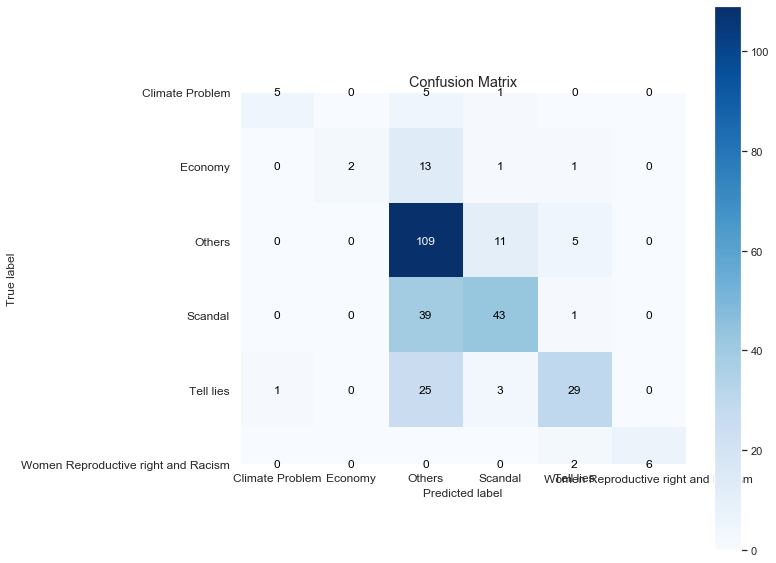

In [0]:
#Plot Confusion Matrix
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test.values, 
    y_test_pred,
    figsize=(10,10))

plt.show()

In [0]:
test_distribution = pd.Series(y_test)
test_distribution.value_counts()

Others                                 125
Scandal                                 83
Tell lies                               58
Economy                                 17
Climate Problem                         11
Women Reproductive right and Racism      8
Name: negative_reason, dtype: int64

The plot above is a confusion matrix of the test set. As mentioned above, most of our error comes from the model predicting as 'Others'. The model is biased towards the class 'other', because of imbalance in the dataset which we can see in the table above showing the distribution of the test set. In addition, another reason is that there aren't enough data to train on for the model to make good predictions. The reason for decent accuracy is because most of our labels in the data is 'other', so having a biased model of 'other' should result in relatively high accuracy.

**For both models, suggest one way you can improve the accuracy of your
models**

1. For the first model, one of the ways to improve the accuracy is by using more complex feature extraction methods like word embedding method such as word2Vac, Doc2Vac, cosine similiarity, etc. and use complex models like BERT.

2. For the second model, we can improve the accuracy by training with larger dataset, but with uniformly distributed classes.